Using device: cpu


C:\Users\mrnai\AppData\Local\Temp\ipykernel_55048\4285566214.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=device)


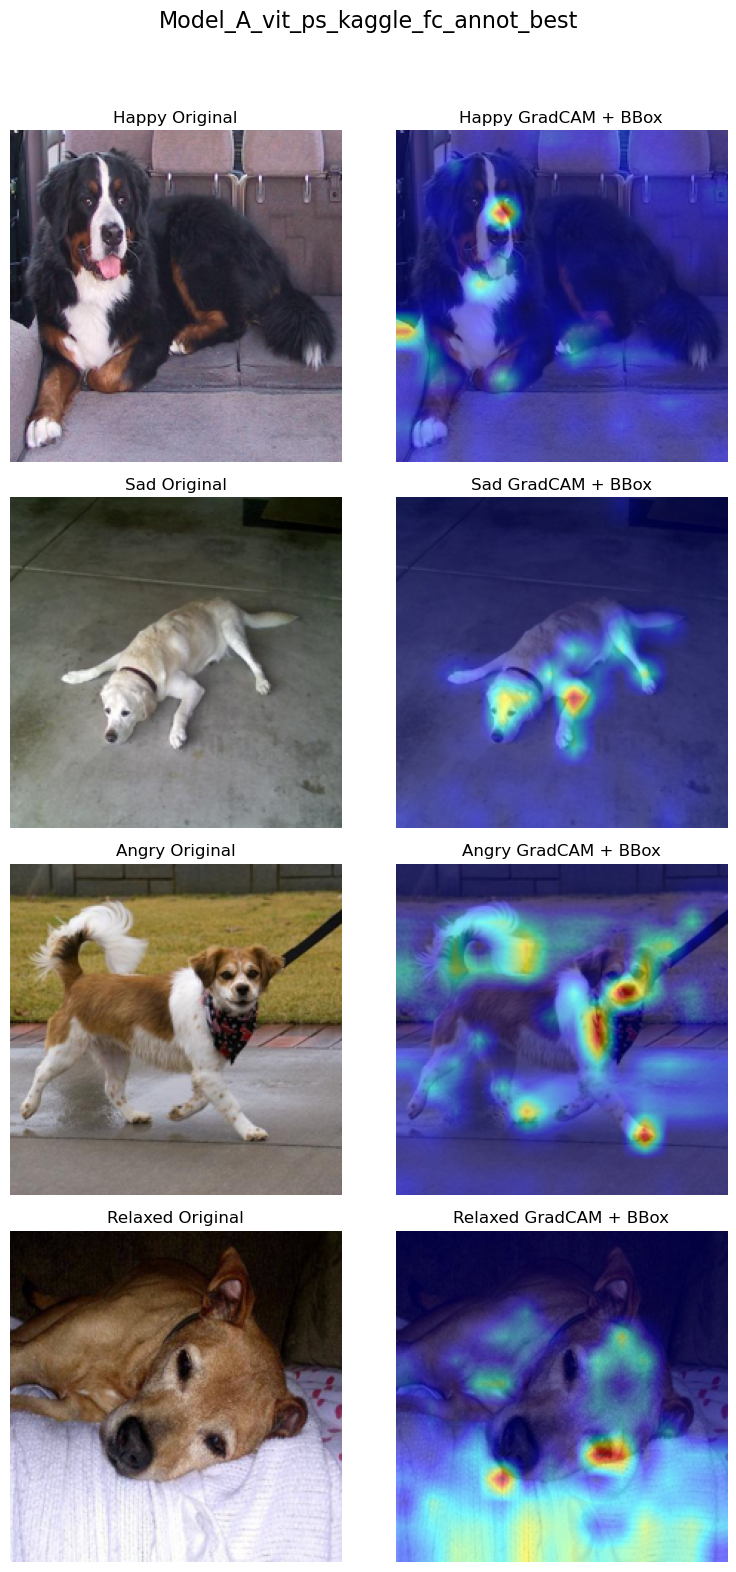

Saved: gradcam_annot_results\Model_A_vit_ps_kaggle_fc_annot_best.png


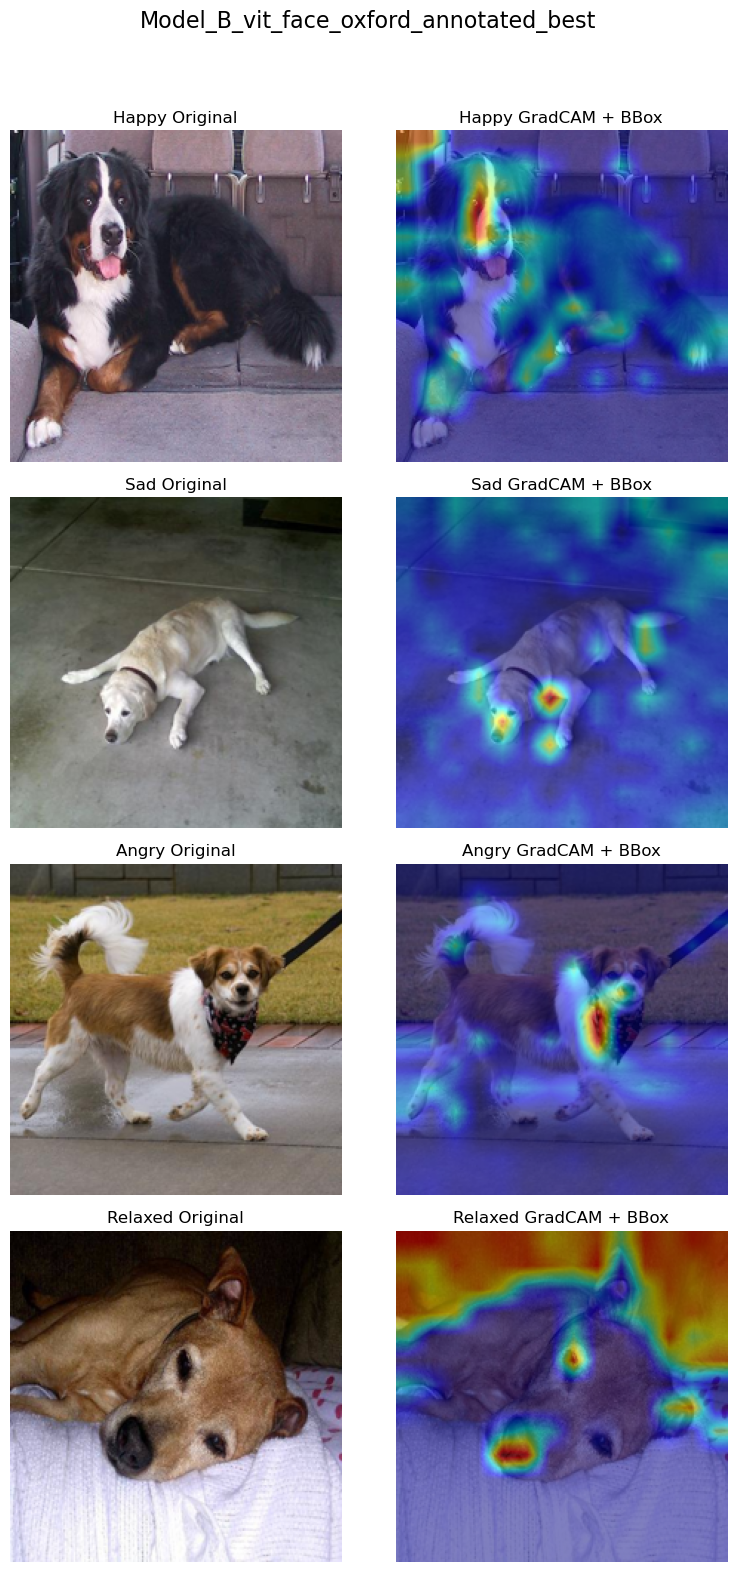

Saved: gradcam_annot_results\Model_B_vit_face_oxford_annotated_best.png


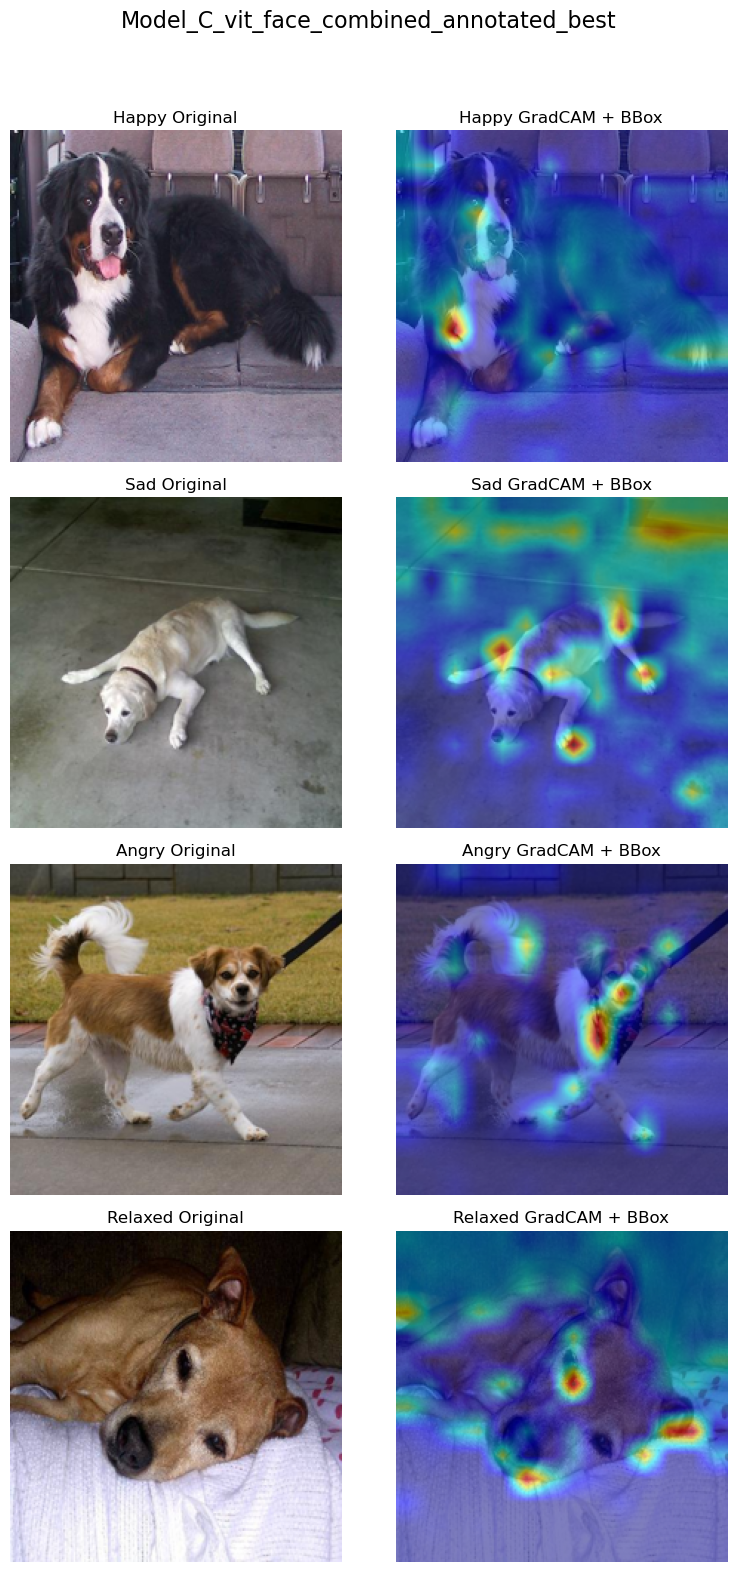

Saved: gradcam_annot_results\Model_C_vit_face_combined_annotated_best.png


In [42]:
import os
import torch
import numpy as np
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) model loader (now annot=True for 4‑channel input)
def load_model_using_weight_file(file_path, annot=True):
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
    if annot:
        # swap patch embedding to accept 4‑chan inputs
        model.patch_embed.proj = torch.nn.Conv2d(
            in_channels=4,
            out_channels=model.patch_embed.proj.out_channels,
            kernel_size=16,
            stride=16,
        )
    checkpoint = torch.load(file_path, map_location=device)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    return model

def load_yolo_mask(mask_txt_path, img_size=(224,224)):
    W, H = img_size
    mask = np.zeros((H, W), dtype=np.float32)
    boxes = []
    with open(mask_txt_path, 'r') as f:
        for line in f:
            x_c, y_c, w_n, h_n = map(float, line.strip().split())
            box_w, box_h = w_n*W, h_n*H
            cx, cy = x_c*W, y_c*H
            x1 = int(cx - box_w/2); x2 = int(cx + box_w/2)
            y1 = int(cy - box_h/2); y2 = int(cy + box_h/2)
            x1, x2 = max(0,x1), min(W,x2)
            y1, y2 = max(0,y1), min(H,y2)
            mask[y1:y2, x1:x2] = 1.0
            boxes.append((x1,y1,x2,y2))
    return mask, boxes
    
def load_rgb_and_yolo_mask(rgb_path, yolo_txt_path, size=(224,224)):
    # load & resize RGB
    rgb_pil = Image.open(rgb_path).convert("RGB").resize(size)
    rgb = np.array(rgb_pil).astype(np.float32) / 255.0   # H×W×3

    # build mask from YOLO
    mask, boxes = load_yolo_mask(yolo_txt_path, img_size=size)  # H×W

    # stack into H×W×4
    combined = np.dstack([rgb, mask])
    return combined, rgb, boxes

# 3) reshape transform for ViT
def reshape_transform(tensor, H=14, W=14):
    x = tensor[:, 1:, :].reshape(tensor.size(0), H, W, tensor.size(-1))
    return x.permute(0, 3, 1, 2)

# 4) your 3 “with‑annotation” models
models_info = [
    ("Model_A_vit_ps_kaggle_fc_annot_best", "C:/Users/mrnai/Downloads/CV/vit_ps_kaggle_fc_annot_best.pth"),
    ("Model_B_vit_face_oxford_annotated_best", "C:/Users/mrnai/Downloads/CV/vit_face_oxford_annotated_best.pth"),
    ("Model_C_vit_face_combined_annotated_best", "C:/Users/mrnai/Downloads/CV/vit_face_combined_annotated_best.pth"),
]

# 5) your 4 emotion images + their .txt annotations
emotion_data = [
    ("Happy",   "happy_new.png",   "happy_new.txt"),
    ("Sad",     "sad_new.png",     "sad_new.txt"),
    ("Angry",   "angry_new.png",   "angry_new.txt"),
    ("Relaxed", "relaxed_new.png", "relaxed_new.txt"),
]

# # 6) ImageNet normalization stats
# mean = np.array(timm.data.constants.IMAGENET_DEFAULT_MEAN, dtype=np.float32)
# std  = np.array(timm.data.constants.IMAGENET_DEFAULT_STD,  dtype=np.float32)
rgb_mean = list(timm.data.constants.IMAGENET_DEFAULT_MEAN)
rgb_std  = list(timm.data.constants.IMAGENET_DEFAULT_STD)
mean4 = torch.tensor(rgb_mean + [0.0], device=device)[:, None, None]
std4  = torch.tensor(rgb_std  + [1.0], device=device)[:, None, None]

# 7) where to save
out_dir = "gradcam_annot_results"
os.makedirs(out_dir, exist_ok=True)

# 8) loop over annotation‑models
for model_name, model_path in models_info:
    model = load_model_using_weight_file(model_path, annot=True).to(device)
    cam   = GradCAM(
        model=model,
        target_layers=[model.patch_embed.proj]
    )

    fig, axes = plt.subplots(len(emotion_data), 2, figsize=(8, 4*len(emotion_data)))
    fig.suptitle(model_name, fontsize=16)

    for i, (label, img_path, mask_txt) in enumerate(emotion_data):
        # Load image
        pil = Image.open(img_path).convert("RGB").resize((224,224))
        rgb = np.array(pil).astype(np.float32) / 255.0

        # Load mask + boxes
        mask, boxes = load_yolo_mask(mask_txt, img_size=(224,224))

        # Stack into 4‑ch and normalize
        combined = np.dstack([rgb, mask])                       # H×W×4
        inp = torch.from_numpy(combined.transpose(2,0,1))      # 4×224×224
        inp = (inp.unsqueeze(0).to(device) - mean4) / std4     # 1×4×224×224

        # GradCAM
        with torch.no_grad():
            logits = model(inp)
        pred = logits.argmax(dim=1).item()
        gcam = cam(input_tensor=inp, targets=[ClassifierOutputTarget(pred)])[0]
        overlay = show_cam_on_image(rgb, gcam, use_rgb=True)

        # Plot original
        ax1 = axes[i,0]
        ax1.imshow(rgb)
        ax1.set_title(f"{label} Original")
        ax1.axis("off")

        # Plot GradCAM + bbox
        ax2 = axes[i,1]
        ax2.imshow(overlay)
        ax2.set_title(f"{label} GradCAM + BBox")
        ax2.axis("off")

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    # ----- save one composite image per model -----
    save_path = os.path.join(out_dir, f"{model_name}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")

    plt.close(fig)

In [29]:
model.patch_embed.proj

Conv2d(4, 768, kernel_size=(16, 16), stride=(16, 16))